In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
import datetime 
import time

data = pd.read_csv('/Users/djmore/Udacity/machine-learning/projects/airbnb/AirBNB.csv')
df = pd.DataFrame(data)

/Users/djmore/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/djmore/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#Fill columns that have null values to 0
#Fill missing dates with todays date to later calculate elapsed days features

df.fillna(0, inplace=True)
df.loc[df.first_review == 0,'first_review'] = datetime.datetime.today().strftime("%Y-%m-%d")
df.loc[df.last_review == 0,'last_review']   = datetime.datetime.today().strftime("%Y-%m-%d")
df.loc[df.host_since == 0,'host_since']     = datetime.datetime.today().strftime("%Y-%m-%d")

### Data Preprocessing

#### Cleaning_fee is a boolean, change it to object type for label encoding

In [3]:
df['cleaning_fee'] = df['cleaning_fee'].astype('object')


#### Feature engineering of all date columns.
#### We convert it to number of days - numerical feature that measures elapsed time

In [4]:
#Elapsed time calculation

import datetime
current_time = datetime.datetime.now()

df['host_since_elapsed'] = (datetime.datetime.now() - pd.to_datetime(df['host_since'])).dt.days
df['first_review_elapsed'] = (datetime.datetime.now() - pd.to_datetime(df['first_review'])).dt.days
df['last_review_elapsed'] = (datetime.datetime.now() - pd.to_datetime(df['last_review'])).dt.days

df.head(5)


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,host_since_elapsed,first_review_elapsed,last_review_elapsed
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,2304,759,729
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,393,346,297
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,630,443,306
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,Lower Haight,0,0.0,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0,1185,0,0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,Columbia Heights,4,40.0,0,20009,0.0,1.0,1234,1162,541


#### Let's count how many amenities each listing has and use that as numerical feature for in our model.

In [5]:
amenities_list = []

for amenity in df.amenities:
    amenity = amenity[1:]
    amenity = amenity[:-1]
    x = amenity.split()
    amenities_list.append(len(x))

df['number_of_amenities'] = amenities_list



In [6]:
df['number_of_amenities'].head(5)


0     7
1     9
2    15
3    11
4     9
Name: number_of_amenities, dtype: int64

#### LabelEncoding of all categorical features

In [7]:
from sklearn import preprocessing

for column in df.columns:
   if df[column].dtype == object:
        label = preprocessing.LabelEncoder()
        label.fit(list(df[column].values))
        df[column] = label.transform(list(df[column].values))
        

#### Drop columns that we are not going to use for regression modeling.
#### Set our target variable log_price to y.

In [8]:
# Assign log_price to y - our target variable
y = df['log_price']

# Remove row index and target columns
df.drop('id',inplace=True,axis=1)
df.drop('log_price',inplace=True,axis=1)

# Remove date columns since we engineered those into elpased days feature columns
df.drop('first_review',inplace=True,axis=1)
df.drop('host_since',inplace=True,axis=1)
df.drop('last_review',inplace=True,axis=1)

# Remove columns that are not part of the model
df.drop('description',inplace=True,axis=1)
df.drop('host_response_rate',inplace=True,axis=1)
df.drop('latitude',inplace=True,axis=1)
df.drop('longitude',inplace=True,axis=1)
df.drop('name',inplace=True,axis=1)
df.drop('thumbnail_url',inplace=True,axis=1)

In [9]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 22 columns):
property_type             74111 non-null int64
room_type                 74111 non-null int64
amenities                 74111 non-null int64
accommodates              74111 non-null int64
bathrooms                 74111 non-null float64
bed_type                  74111 non-null int64
cancellation_policy       74111 non-null int64
cleaning_fee              74111 non-null int64
city                      74111 non-null int64
host_has_profile_pic      74111 non-null int64
host_identity_verified    74111 non-null int64
instant_bookable          74111 non-null int64
neighbourhood             74111 non-null int64
number_of_reviews         74111 non-null int64
review_scores_rating      74111 non-null float64
zipcode                   74111 non-null int64
bedrooms                  74111 non-null float64
beds                      74111 non-null float64
host_since_elapsed        74111 non-n

#### We will use GradientBoostingRegressor as our primary model 
#### and fine tune its hyper parameters to get the lowest MSE

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import multiprocessing

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=20)
params = {
            "n_estimators"      : [400,500],
            "max_depth"         : [4,5],
            "min_samples_split" : [3,4],
            "learning_rate"     : [0.02,0.03]
         }          

model = GradientBoostingRegressor()  
gbr_cv    = GridSearchCV(model,params,verbose = 0,scoring='mean_squared_error',verbose=True, n_jobs=-1)
gbr_cv.fit(X_train, y_train) 

#print ('Best Score :', gbr_cv.best_score_)
print ('Best Parameters :', gbr_cv.best_params_)
print ('Best Estimator :', gbr_cv.best_estimator_)
print ('Mean Square Error : ',mean_squared_error(y_test, gbr_cv.predict(X_test)))
print ('Grid Search Scores')
print(gbr_cv.grid_scores_)


SyntaxError: keyword argument repeated (<ipython-input-10-e36b207559cf>, line 14)

#### We will use XGBoost Regressor as 2nd test model 
#### and fine tune its hyper parameters to get the lowest MSE and
#### compare it with GBR.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import multiprocessing
from sklearn.metrics import mean_squared_error


X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=20)

ncpu = multiprocessing.cpu_count()
params = {
            "nthread" : [ncpu],
            "max_depth": [3,4,5,7,9],
            "min_child_weight": [1,10,50,100],
            "n_estimators": [400,500],
            "subsample" : [0.5, 0.8, 1],
            "colsample_bytree" : [0.5, 1],
            "learning_rate":[0.02,0.03],
            "n_jobs" : [-1]
         }

model = XGBRegressor()
xgb_cv    = GridSearchCV(model,params,verbose = 0,scoring='neg_mean_squared_error')
xgb_cv.fit(X_train, y_train)  

print ('Best Score :', xgb_cv.best_score_)
print ('Best Parameters :', xgb_cv.best_params_)
print ('Best Estimator :', xgb_cv.best_estimator_)
print ('Mean Square Error : ',mean_squared_error(y_test, xgb_cv.predict(X_test)))

print ('Grid Search Scores')
print(xgb_cv.grid_scores_)

MSE: 0.1548


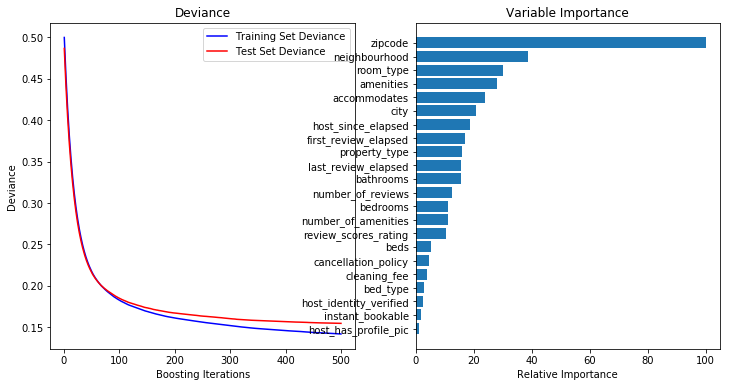

In [14]:
from sklearn.ensemble import GradientBoostingRegressor 
import xgboost as xgb
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=20)

# #############################################################################
# Fit regression model
# with the best tuned hyper-parameters from above
#
params = {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 4,
          'learning_rate': 0.03, 'loss': 'ls'}


clf = GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [16]:
from sklearn.model_selection import cross_val_score
predict = cross_val_score(clf, df, y, scoring='mean_squared_error', cv=10, verbose=True)
display(predict.mean())



-0.2876455547633057

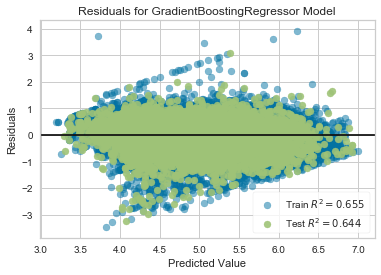

In [124]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(clf)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw residual plot

MSE: 0.1417


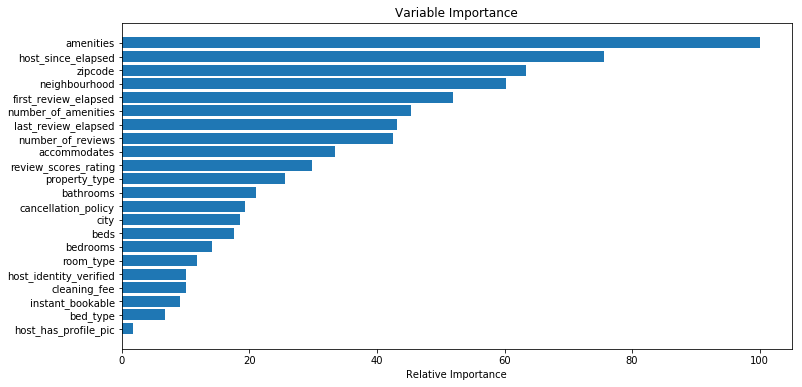

In [11]:
from sklearn.ensemble import GradientBoostingRegressor 
import xgboost as xgb
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=20)

# #############################################################################
# Fit regression model
# with the best tuned hyper-parameters from above
#
params = {'colsample_bytree': 0.5, 'learning_rate': 0.03, 'max_depth': 9, \
          'min_child_weight': 1, 'n_estimators': 500, 'nthread': 4, 'subsample': 0.8, 'n_jobs':-1}


clf = xgb.XGBRegressor(**params)
clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


In [12]:
## XGBoost Cross Validation Score
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
predict = cross_val_score(clf, df, y, scoring='mean_squared_error', cv=10, verbose=True)
display(predict.mean())

/Users/djmore/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/djmore/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/djmore/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/djmore/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed 

-0.14214153349834122

In [14]:
display(predict)

array([-0.14955952, -0.13642466, -0.14125585, -0.14711599, -0.13452588,
       -0.13916288, -0.14304137, -0.14185499, -0.14169577, -0.14677843])